### 機器學習百日馬拉松期中練習測驗

- 本賽題提供用戶在2016年1月1日至2016年5月31日之間真實線下消費行為，預測用戶在2016年6月領取優惠券後15天以內的使用情況。 
- [練習競賽網頁](https://www.kaggle.com/t/2eaf9a8ed13847cd9c26f05b2abfe966)
- [baseline kernel參考](https://www.kaggle.com/ml100marathon/baseline-example)


In [44]:
import numpy as np
import pandas as pd
import dateutil.parser as date_parser
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
# 檢視資料欄位描述
column_desc_df = pd.read_csv('data/midterm/column_description.csv', encoding = 'big5')
for i in column_desc_df.index:
    print('{:<30}\t{:<50}'.format(column_desc_df.ix[i][0], column_desc_df.ix[i][1]))

User_id                       	用戶 ID                                             
Merchant_id                   	商家 ID                                             
Coupon_id                     	優惠券 ID (null 代表無優惠券消費)                            
Discount_rate                 	優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元                 
Distance                      	用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 10 表示大於 5 公里。
Date_received                 	優惠券取得時間                                           
Date                          	購買商品時間 (如果 Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; 若為 Date is not null & Coupon_id is null, 則為普通消費日期; 若 Date is not null & Coupon_id is not null, 則表示優惠券消費日期)


In [3]:
# 檢視訓練資料
train_df = pd.read_csv('data/midterm/train_offline.csv', encoding = 'big5')
print(train_df.dtypes)
train_df.sample(n = 10)

User_id            int64
Merchant_id        int64
Coupon_id        float64
Discount_rate     object
Distance         float64
Date_received    float64
Date             float64
dtype: object


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
503938,3676806,6184,8505.0,10:1,NaN,20160416.0,NaN
600927,3692323,3262,NaN,NaN,0.0,NaN,20160416.0
56204,3973100,2099,NaN,NaN,0.0,NaN,20160214.0
964584,6460509,4242,NaN,NaN,0.0,NaN,20160324.0
928425,1976433,7557,971.0,10:5,0.0,20160327.0,20160328.0
987792,3648287,2099,12034.0,100:10,NaN,20160207.0,NaN
623437,6679354,3532,NaN,NaN,0.0,NaN,20160306.0
170690,6284909,209,NaN,NaN,0.0,NaN,20160310.0
761138,5405320,3381,12821.0,200:20,0.0,20160123.0,NaN
820885,2545624,1041,13490.0,30:5,0.0,20160128.0,NaN


In [4]:
# 缺失值偵測

print('{:<25}\t{:>10}'.format('Column','isNa'))
print('-'*50)
for c in train_df.columns:
    print('{:<25}\t{:>10}'.format(c, np.unique(train_df[c].isna()).size > 1))

Column                   	      isNa
--------------------------------------------------
User_id                  	         0
Merchant_id              	         0
Coupon_id                	         1
Discount_rate            	         1
Distance                 	         1
Date_received            	         1
Date                     	         1


In [5]:
# 缺失值處理
# Coupon_id, Date_received, Date 缺失者不處理
# Discount_rate 缺失者補上1.0
# Distance 缺失者補上眾數
train_df['Discount_rate'].fillna(1.0, inplace=True)
train_df['Distance'].fillna(train_df['Distance'].mean(), inplace=True)

In [6]:
# 各月份使用優惠券消費的次數 (月份0者，代表無使用優惠券消費)
train_df['coupon_shoping_month'] = train_df[(np.isnan(train_df['Date']) == False) & (np.isnan(train_df['Coupon_id']) == False)]['Date'].apply(lambda d : int(str(int(d))[4:6]))
train_df['coupon_shoping_month'].fillna(0, inplace = True)
train_df['coupon_shoping_month'] = train_df['coupon_shoping_month'].astype('int')
train_df[train_df['coupon_shoping_month'] >0]['coupon_shoping_month'].plot.hist(bins=5)

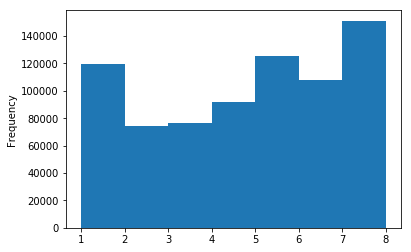

In [7]:
# 優惠券取得日期屬於星期幾(1 Monday - 7 Sunday)

# 用pd.to_datetime, 在macbook上要跑2分鐘
# train_df['Date_received_day_of_week'] = train_df[~np.isnan(train_df['Date_received'])]['Date_received'].apply(lambda d : pd.to_datetime(str(int(d)), format="%Y%m%d").weekday() + 1)
# 用dateutil.parser快多了！ 在macbook上不到5秒
def compute_received_day_of_week(df: pd.DataFrame):
    s = df[~np.isnan(df['Date_received'])]['Date_received'].apply(lambda d : date_parser.isoparse(str(int(d))).date().weekday() + 1)
    df['Date_received_day_of_week'] = s
    df['Date_received_day_of_week'].fillna(0, inplace = True)
    df['Date_received_day_of_week'] = df['Date_received_day_of_week'].astype(int)
    # 把優惠券取得日期星期幾換成dummy variable
    weekday_df = pd.get_dummies(train_df['Date_received_day_of_week'], 'Weekday')
    weekday_df.drop(['Weekday_0'], axis=1)
    return pd.concat([df, weekday_df], axis=1)

train_df = compute_received_day_of_week(train_df)
train_df[train_df['Date_received_day_of_week'] > 0]['Date_received_day_of_week'].plot.hist(bins=range(1, 9))

In [8]:
# 把優惠券取得日期星期幾換成dummy variable
weekday_df = pd.get_dummies(train_df['Date_received_day_of_week'], 'Weekday')

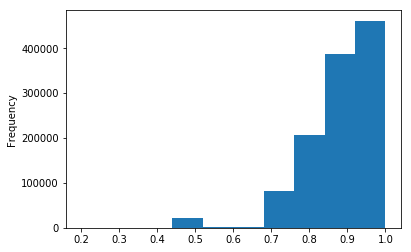

In [9]:
# 折扣率，原Discount_rate可能是小數(0.9)或比例(100:10 滿100減10,其實也等於九折)
def cnvt_discount_rate(rate_obj):
    rate_str = str(rate_obj)
    if rate_str == 'nan':
        return 1
    elif ':' in rate_str:
        _s = rate_str.split(':')
        return 1.0 - float(_s[1])/float(_s[0])
    else:
        return float(rate_str)

train_df['cnvt_discount_rate'] = train_df['Discount_rate'].apply(cnvt_discount_rate)
train_df['cnvt_discount_rate'].plot.hist()

In [10]:
# 產生label
# 我們要學習的是：拿到優惠券的人，會不會在15天內使用，所以還要考慮Date與Date_received的差距
# 在所有資料中，只保留有拿優惠券者進行學習 （捨棄label = -1者）
#
# Date 購買商品時間
#   Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; label=0
#   Date is null & Coupon_id is null, 則該紀錄為沒有優惠券也沒有使用;  label=-1
#   Date is not null & Coupon_id is null, 則為普通消費日期;      label=-1
#   Date is not null & Coupon_id is not null, 則表示優惠券消費日期
#        Date - Date_received <= 15 , label=1
#                             else  , label=0

def compute_date_diff(date: str, date_received: str):
    return (date_parser.isoparse(date) - date_parser.isoparse(date_received)).days

def compute_label(row):
    if (np.isnan(row['Date'])) & (~np.isnan(row['Coupon_id'])):
        return 0
    elif (~np.isnan(row['Date'])) & (~np.isnan(row['Coupon_id'])):
        if compute_date_diff(str(int(row['Date'])), str(int(row['Date_received']))) <= 15:
            return 1
        else:
            return 0
    else:
        return -1
                                     
train_df['label'] = train_df.apply(compute_label, axis=1)
train_df['label'] = train_df['label'].astype(int)
print('label -1 : {:>10}\nlabel  0 : {:>10}\nlabel  1 : {:>10}'. format(
      train_df[train_df['label'] == -1].shape[0], 
      train_df[train_df['label'] == 0].shape[0], 
      train_df[train_df['label'] == 1].shape[0])
)
      

label -1 :     413773
label  0 :     710665
label  1 :      36304


In [28]:
# 整理特徵及訓練樣本，只取label = 0或1者

weekday_features = ['Weekday_' + str(i) for i in range(1,8)]
features = ['cnvt_discount_rate','Distance']
features.extend(weekday_features)

train_X = train_df[train_df['label'] >= 0][features].copy()
train_y = train_df[train_df['label'] >= 0]['label'].copy()

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)

train_train_X, test_train_X, train_train_y, test_train_y = train_test_split(train_X, train_y, test_size=0.2, random_state = 42)


In [29]:
# logistic regression
clf = SGDClassifier(loss='log')
clf.fit(train_train_X, train_train_y)
test_train_y_pred = clf.predict_proba(test_train_X)
print('AUC', roc_auc_score(test_train_y, test_train_y_pred[:, 1]))
print('Accuracy', accuracy_score(test_train_y, np.argmax(test_train_y_pred, axis=1)))

AUC 0.7474516844280479
Accuracy 0.951872230477797


### 處理與預測測試資料

- 處理方式比對上述訓練資料
- 填補缺失值
- 轉換待徵
- 產生測試樣本

In [55]:
# 載入測試資料
test_df = pd.read_csv('data/midterm/test_offline.csv')

# 去掉沒有Coupon_id者
test_df = test_df[~test_df.Coupon_id.isna()]
test_df.reset_index(drop=True, inplace=True)
print(test_df.shape)

# 轉換待徵:
#     優惠券取得日期屬於星期幾
test_df = compute_received_day_of_week(test_df)

# 填補缺失值
test_df['User_id'].fillna(0, inplace = True)
test_df['Merchant_id'].fillna(0, inplace = True)
test_df['Discount_rate'].fillna(1.0, inplace=True)
test_df['Distance'].fillna(test_df['Distance'].mean(), inplace=True)
test_df['Date_received'].fillna(0, inplace=True)

# 加上uid
test_df['uid'] = test_df.apply(lambda row : '{}_{}_{}'.format(int(row['User_id']), int(row['Merchant_id']), int(row['Date_received'])), axis=1)

#     折扣率
test_df['cnvt_discount_rate'] = test_df['Discount_rate'].apply(cnvt_discount_rate)

# 產生測試樣本
test_X = test_df[features].copy()
scaler = StandardScaler()
test_X = scaler.fit_transform(test_X)

# 進行預測
test_y_pred = clf.predict_proba(test_X)
submit_df = pd.DataFrame({'uid': test_df['uid'], 'label': test_y_pred[:, 1]})
submit_df.to_csv('data/midterm/submit_{}.csv'.format(int(datetime.now().timestamp())), index = False)

(306313, 6)
